In [1]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path
import datetime
from importlib import reload

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Import self-made modules
from utils import *
from autoencoder import AutoEncoder

In [3]:
# Reload libraries when changes have been made to them
%reload_ext autoreload
%autoreload 2

In [392]:
# Set file path constants
DATA_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/'

In [424]:
# Set parameters
WIN_SIZE = 20
SENSORS = ['back_angle', 'left_angle', 'right_angle']
no_feats = len(SENSORS)
train_type = 'Patient'

In [425]:
# Obtain test data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-major-test.npy'
path = DATA_FILE_PATH + file_name
testX = np.load(path)
print(f'Number of testing samples: {testX.shape}')

Number of testing samples: (7618, 20, 3)


In [426]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-full-test.npy'
path = DATA_FILE_PATH + file_name
fullX = np.load(path)
fullX.shape

(38167, 20, 3)

In [427]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = f'/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/full-test-{WIN_SIZE}.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['Date'])
patient_df = dataframe.loc[:,SENSORS]
patient_df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'Date'])

patient_df.shape

(38187, 4)

In [428]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = f'/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/major-test-{WIN_SIZE}.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['Date'])
df = dataframe.loc[:,SENSORS]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'Date'])

df.dtypes

back_angle            float64
left_angle            float64
right_angle           float64
Date           datetime64[ns]
dtype: object

In [429]:
# Load the model in
if WIN_SIZE == 20:
    pat_time_code = '110000_0429'
elif WIN_SIZE == 100:
    pat_time_code = '113000_0429'
pat_model_file = f'{pat_time_code}-model.h5'
pat_model_file

'110000_0429-model.h5'

In [430]:
pat = AutoEncoder(None, None, None, None, pat_model_file, DIAGRAM_FILE_PATH)

Checking for 110000_0429-model.h5

Model loaded from: 110000_0429-model.h5
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 15)                1140      
_________________________________________________________________
dropout_18 (Dropout)         (None, 15)                0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 20, 15)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 20, 15)            1860      
_________________________________________________________________
dropout_19 (Dropout)         (None, 20, 15)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 3)             48        
Total params: 3,048
Trainable params: 3,048
N

In [431]:
# Reconstruct train signal
full_reconX = pat.model.predict(fullX)
error = error_computation(fullX, full_reconX)
full_error_df = anomaly_df(patient_df, WIN_SIZE, error, 0)
ylimit = max(full_error_df['error'])
ylimit

0.37548151225092596

In [432]:
# Reconstruct test signal
reconX = pat.model.predict(testX)
reconX.shape

(7618, 20, 3)

In [433]:
# example_plot(4432, no_feats, WIN_SIZE, testX, reconX, f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, save_on=False, docplot=2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/error-thresh-True-None-MAE-W=20, Train=Patient-5.png


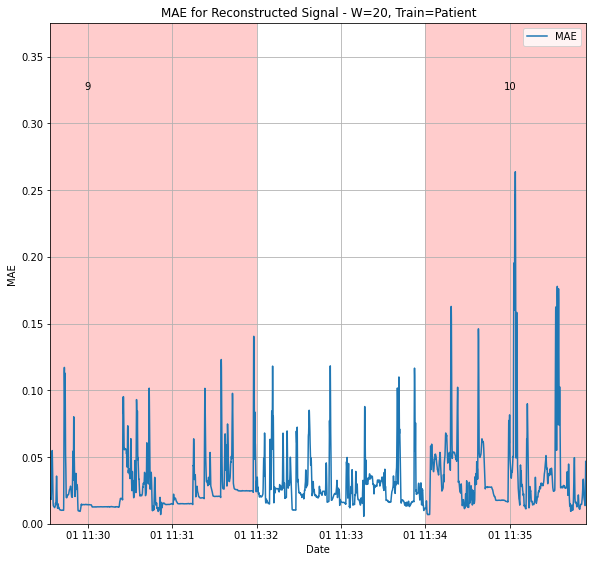

In [434]:
error = error_computation(testX, reconX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
start = error_df['Date'].iloc[0]
end = error_df['Date'].iloc[-1]
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, tstart=start, tend=end, pct=None, save_new=True, regions=True, ylimits=(0, ylimit))

In [435]:
train_type = 'Augment'

In [436]:
# Obtain test data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-minor-test.npy'
path = DATA_FILE_PATH + file_name
testX = np.load(path)
print(f'Number of testing samples: {testX.shape}')

Number of testing samples: (22893, 20, 3)


In [437]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-augment-train.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (27276, 20, 3)


In [438]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = f'/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/minor-test-{WIN_SIZE}.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['Date'])
df = dataframe.loc[:,SENSORS]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'Date'])

df.dtypes

back_angle            float64
left_angle            float64
right_angle           float64
Date           datetime64[ns]
dtype: object

In [439]:
# Load the model in
if WIN_SIZE == 20:
    aug_time_code = '111000_0429'
elif WIN_SIZE == 100:
    aug_time_code = '114000_0429'
aug_model_file = f'{aug_time_code}-model.h5'
aug_model_file

'111000_0429-model.h5'

In [440]:
aug = AutoEncoder(None, None, None, None, aug_model_file, DIAGRAM_FILE_PATH)

Checking for 111000_0429-model.h5

Model loaded from: 111000_0429-model.h5
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 15)                1140      
_________________________________________________________________
dropout_20 (Dropout)         (None, 15)                0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 20, 15)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 20, 15)            1860      
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 15)            0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 3)             48        
Total params: 3,048
Trainable params: 3,048


In [441]:
# Reconstruct train signal
full_reconX = aug.model.predict(fullX)
error = error_computation(fullX, full_reconX)
full_error_df = anomaly_df(patient_df, WIN_SIZE, error, 0)
ylimit = max(full_error_df['error'])
ylimit

0.36356650501730636

In [442]:
# Reconstruct test signal
reconX = aug.model.predict(testX)
reconX.shape

(22893, 20, 3)

In [443]:
# example_plot(4432, no_feats, WIN_SIZE, testX, reconX, f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, save_on=False, docplot=2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/error-thresh-True-None-MAE-W=20, Train=Augment-5.png


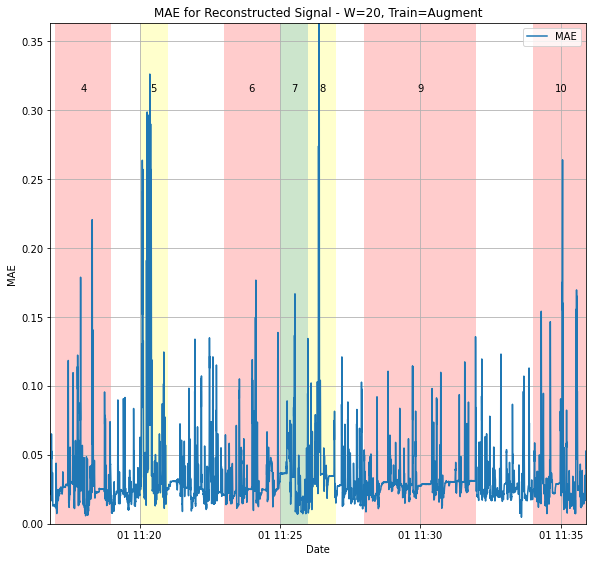

In [444]:
error = error_computation(testX, reconX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
start = error_df['Date'].iloc[0]
end = error_df['Date'].iloc[-1]
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, tstart=start, tend=end, pct=None, save_new=True, regions=True, ylimits=(0, ylimit))

In [445]:
train_type = 'Control'

In [446]:
# Obtain test data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-patient-full-test.npy'
path = DATA_FILE_PATH + file_name
testX = np.load(path)
print(f'Number of testing samples: {testX.shape}')

Number of testing samples: (38167, 20, 3)


In [447]:
# Obtain training data
file_version = f'ws{WIN_SIZE}num{no_feats}derFalse'
file_name = f'{file_version}-augment-train.npy'
path = DATA_FILE_PATH + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (27276, 20, 3)


In [448]:
# Retrieve test data for plotting and place with pd dataframe
patient_file_path = f'/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/full-test-{WIN_SIZE}.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['Date'])
df = dataframe.loc[:,SENSORS]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'Date'])

df.dtypes

back_angle            float64
left_angle            float64
right_angle           float64
Date           datetime64[ns]
dtype: object

In [449]:
# Load the model in
if WIN_SIZE == 20:
    con_time_code = '112000_0429'
elif WIN_SIZE == 100:
    con_time_code = '115000_0429'
con_model_file = f'{con_time_code}-model.h5'
con_model_file

'112000_0429-model.h5'

In [450]:
con = AutoEncoder(None, None, None, None, con_model_file, DIAGRAM_FILE_PATH)

Checking for 112000_0429-model.h5

Model loaded from: 112000_0429-model.h5
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 15)                1140      
_________________________________________________________________
dropout_22 (Dropout)         (None, 15)                0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 20, 15)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 20, 15)            1860      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 15)            0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 3)             48        
Total params: 3,048
Trainable params: 3,048


In [451]:
# Reconstruct train signal
full_reconX = con.model.predict(fullX)
error = error_computation(fullX, full_reconX)
full_error_df = anomaly_df(patient_df, WIN_SIZE, error, 0)
ylimit = max(full_error_df['error'])
ylimit

0.21532223399361688

In [452]:
# Reconstruct test signal
reconX = con.model.predict(testX)
reconX.shape

(38167, 20, 3)

In [453]:
# example_plot(4432, no_feats, WIN_SIZE, testX, reconX, f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, save_on=False, docplot=2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/report/error-thresh-True-None-MAE-W=20, Train=Control-7.png


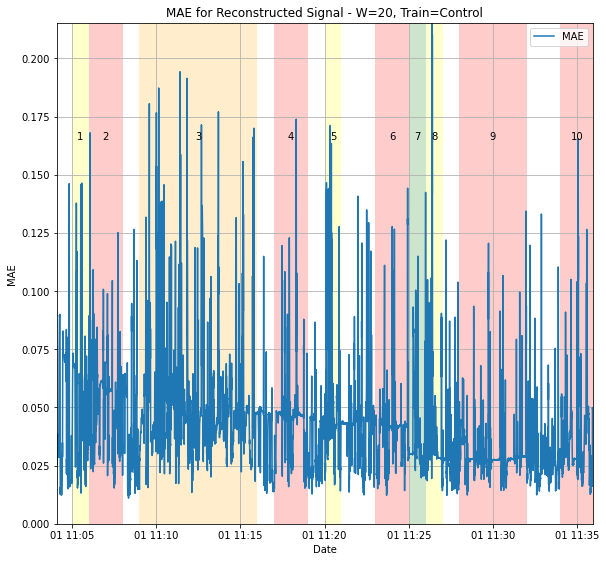

In [454]:
error = error_computation(testX, reconX)
error_df = anomaly_df(df, WIN_SIZE, error, 0)
start = error_df['Date'].iloc[0]
end = error_df['Date'].iloc[-1]
_, plot = error_vs_thresh_plot_and_save(error_df, 'MAE', f'W={WIN_SIZE}, Train={train_type}', DIAGRAM_FILE_PATH, tstart=start, tend=end, pct=None, save_new=True, regions=True, ylimits=(0,ylimit))